In [2]:
import math
import urllib.request
import pickle
import pandas            as pd
import numpy             as np
import matplotlib.cm     as cm
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from   matplotlib.pyplot import figure
from   matplotlib.colors import LogNorm
from   statistics        import NormalDist
from   numpy             import *
from   scipy             import stats
from   scipy             import optimize
from   scipy.stats       import norm
from   scipy.stats       import chisquare
from   scipy.optimize    import newton
from   scipy.optimize    import brentq
from   scipy.optimize    import fmin
from   scipy.optimize    import minimize
from   scipy.optimize    import minimize_scalar
from   scipy.interpolate import interp1d
%matplotlib inline

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [3]:
def f( x ):
    return [(4 - (2.1*x[0]*x[0]) +
            (((x[0])**4)/3))*x[0]*x[0] + 
            x[0]*x[1] + 
            (4*x[1]*x[1] -4)*x[1]*x[1]]

# find the minima:
X = []
for i in range (-20, 20):
    for j in range (-10, 10):
        m = minimize( f, (i/10, j/10), method='SLSQP')
        x, y = round( m.x[0], 2), round( m.x[1], 2)
        X.append([x,y])

Z = np.unique( X, axis = 0 )
#Z = np.unique( X, axis = 1 )

F = []
for i in range (Z.shape[0]):
    F.append(f(Z[i]))

index = 0
M     = []
print('The global minima of the function and the function value are: ')
for i in range (Z.shape[0]):
    if ( F[i] == min( F ) ):
        M.append(Z[i])
        print('[x,y] =', Z[i],', f(x,y) =', F[i])
        index = index + 1
    
print('So, there are', index, 'global minima')    

print('In (0,0) there is a saddle point but the algorithm converge:')
m = minimize(f, (0,0), method='SLSQP')
print(m)

The global minima of the function and the function value are: 
[x,y] = [-0.09  0.71] , f(x,y) = [-1.0315703638529998]
[x,y] = [ 0.09 -0.71] , f(x,y) = [-1.0315703638529998]
So, there are 2 global minima
In (0,0) there is a saddle point but the algorithm converge:
     fun: 0.0
     jac: array([ 5.96046448e-08, -5.96046448e-08])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0., 0.])


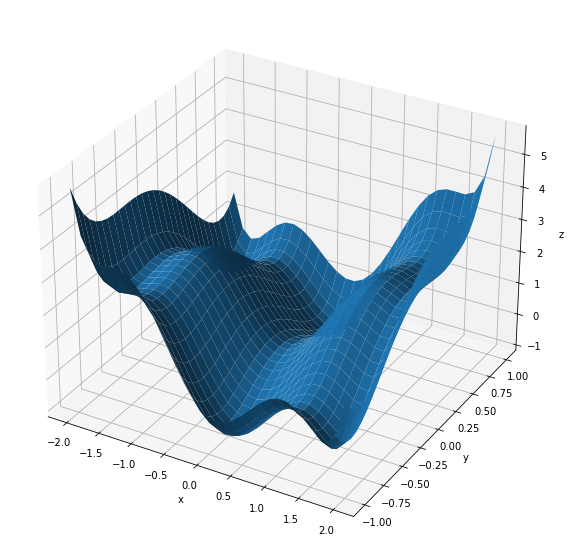

In [4]:
def f( x, y ):
    return ( 4 - (2.1*x*x) + (((x)**4)/3))*x*x + x*y + ( 4*y*y -4 )*y*y

x = np.linspace( -2, 2, 30 )
y = np.linspace( -1, 1, 30 )

X, Y = np.meshgrid( x, y )
Z    = f( X, Y )
ax   = plt.figure( figsize = ( 15, 10 ) )

ax   = plt.axes( projection = '3d', 
                 label ='z' )

ax.plot_surface( X, Y, Z, 
                 rstride = 1, 
                 cstride = 1,
                 #cmap    = 'viridis',
                 edgecolor = 'none' )
ax.set_xlabel( 'x' )
ax.set_ylabel( 'y' )
ax.set_zlabel( 'z' );

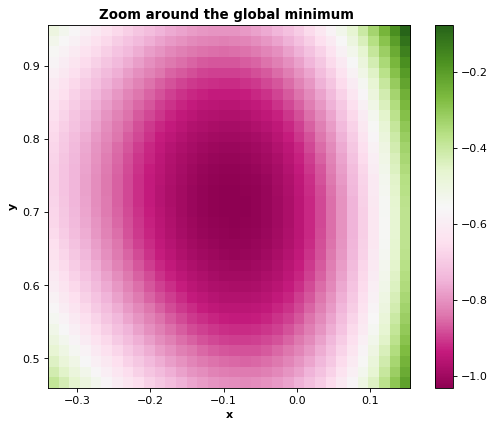

For the other global minimum the plot is the same because f( x, y ) is an odd function.


In [5]:
dx, dy, r = 0.015, 0.015, 0.25

x, y = np.mgrid[ slice( -r + M[0][0], M[0][0] + r, dx),
                 slice( -r + M[0][1], M[0][1] + r, dy)]

z = f( x, y )

z_min, z_max =  z.min(), z.max()
figure(figsize=(8, 6), dpi=80)
c = plt.imshow( z,             
                cmap   = 'PiYG',  
                vmin   = z_min, 
                vmax   = z_max,  
                origin = 'lower',
                extent = [x.min(), x.max(), y.min(), y.max()],
                interpolation = 'nearest' )
plt.colorbar( c )
  
plt.title( 'Zoom around the global minimum ', 
                        fontweight = 'bold' )

plt.xlabel( 'x', fontweight = 'bold' )
plt.ylabel( 'y', fontweight = 'bold' )

plt.show( )

print('For the other global minimum the plot is the same because f( x, y ) is an odd function.')

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Chi^(2) for Tmax and Tmin:
1.94, 3.54
For 8 degrees of feeedom the values look quite small but the fit is still reasonable
Is the time offset for min and max temperatures the same within the fit accuracy?
Time_Tmax = (5.74 +/- 0.08) months
Time_Tmin = (6.16 +/- 0.05) months
Compatibility = 4.64 : the two parameters are not compatible.


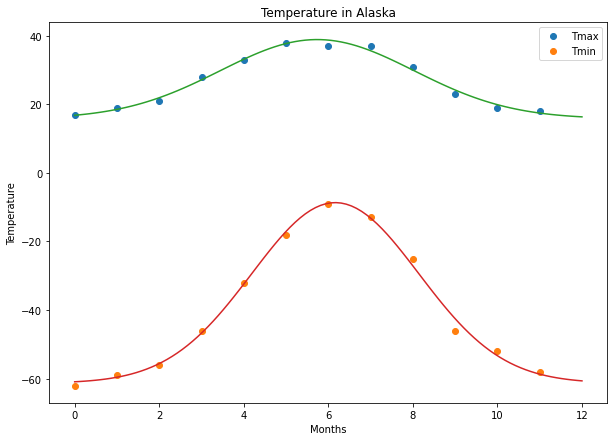

In [8]:
months = np.arange( 12 )
Tmax = [ 17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18]
Tmin = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]
errTmax = np.sqrt( Tmax )
errTmin = np.sqrt( np.abs(Tmin) )

plt.figure( figsize = ( 10, 7 ))
plt.plot( months, 
          Tmax, 
          'o', 
          ms = 6, 
          label = 'Tmax' )

plt.plot( months, 
          Tmin, 
          'o', 
          ms = 6, 
          label = 'Tmin' )
plt.title ( 'Temperature in Alaska' )
plt.xlabel( 'Months' )
plt.ylabel( 'Temperature' )

def gauss_function( x, N, mu, sigma, bias ):
    return ( N*np.exp( -( x - mu )**2/( 2*sigma**2 ))) + bias

( N1, mu1, sigma1, bias1 ), cov1 = optimize.curve_fit( gauss_function, 
                                                       months, 
                                                       Tmax )

( N2, mu2, sigma2, bias2 ), cov2 = optimize.curve_fit( gauss_function, 
                                                       months, 
                                                       Tmin,
                                                       [10, 6, 1.5, 10])

x  = np.linspace( 0, 12, 100 )
y1 = gauss_function( x, N1, mu1, sigma1, bias1 )
y2 = gauss_function( x, N2, mu2, sigma2, bias2 )
plt.plot( x, y1 )
plt.plot( x, y2 )
plt.legend( loc = 'best' )

# calcolo chi^2
residuals_square_1 = [ i*i for i in gauss_function( months, N1, mu1, sigma1, bias1 ) - Tmax ]
residuals_square_2 = [ i*i for i in gauss_function( months, N2, mu2, sigma2, bias2 ) - Tmin ]

sum1,     sum2 = 0, 0
chi2_1, chi2_2 = 0, 0

for i in range ( months.shape[0] ):
    sum1 = sum1 + ( residuals_square_1[i]/ errTmax[i])
    sum2 = sum2 + ( residuals_square_2[i]/ errTmin[i])

dof    = months.shape[0] - 4 
chi2_1 = sum1 
chi2_2 = sum2 
print("Chi^(2) for Tmax and Tmin:")
print('%.2f, %.2f'% (chi2_1, chi2_2))
#print(chisquare( Tmax, gauss_function( days, N1, mu1, sigma1, bias1 )))
#print(chisquare( Tmin, gauss_function( days, N2, mu2, sigma2, bias2 ), ddof = 4))
print('For', dof, 'degrees of feeedom the values look quite small but the fit is still reasonable')

print('Is the time offset for min and max temperatures the same within the fit accuracy?')
print('Time_Tmax = (%.2f +/- %.2f) months' % ( mu1, np.sqrt(cov1[1,1])))
print('Time_Tmin = (%.2f +/- %.2f) months' % ( mu2, np.sqrt(cov2[1,1])))
l = abs( mu1 - mu2 )/sqrt( cov1[1,1] + cov2[1,1] )
print('Compatibility = %.2f'% l, ': the two parameters are not compatible.')


3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

n degrees of freedom = 98
chi2 = 6646.32
p-value = 0.0
The p-value is smaller than 5% so the fit is considered unsatisfactory.


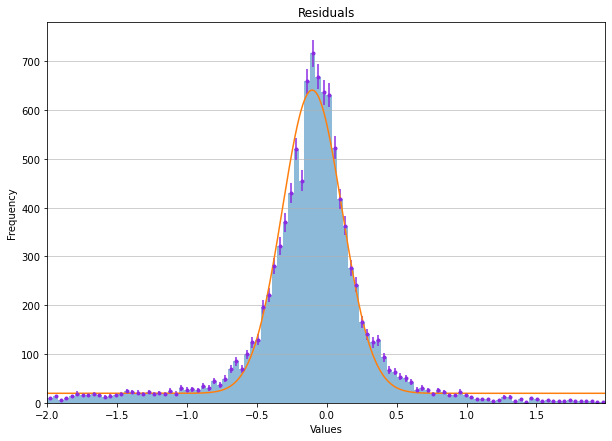

In [9]:
import matplotlib.pyplot as plt

f    = np.load( 'data/residuals_261.pkl', allow_pickle = True ) 
a    = f.item( ) 
df   = pd.DataFrame( a )
df   = df.mask( abs( df['residuals'] ) > 2 )
df   = df.dropna( how = 'any' )
df 

fig, ( plt ) = plt.subplots( nrows = 1, 
                             ncols = 1, 
                             figsize = (10, 7) )

N  = df['residuals'].shape
bin_count = int( np.sqrt( N ) )
n, bins, patches = plt.hist( x      = df['residuals'], 
                             bins   = bin_count,
                             alpha  = 0.5, 
                             rwidth = 1 )

Xmin = df['residuals'].min()
Xmax = df['residuals'].max()

plt.set_xlim( xmin = Xmin, 
              xmax = Xmax )

errors = [ math.sqrt( x ) for x in n ]
plt.grid( axis = 'y', alpha = 0.75 )
plt.set_xlabel( 'Values' )
plt.set_ylabel( 'Frequency' )
plt.set_title ( 'Residuals' )

bincenters = ( bins[1:] + bins[:-1] ) / 2

plt.errorbar( bincenters, 
              n,
              yerr   = errors,
              marker = '.',
              fmt    = '.',
              color  = 'blueviolet' )

#norm = NormalDist.from_samples( df['residuals'] )
#mu, sigma = norm.mean, norm.stdev
#print( mu, sigma )
Bins  = np.delete( bins, len( bins ) - 1 ) 

def gauss_function( x, N, mu, sigma, bias ):
    return ( N*np.exp( -( x - mu )**2/( 2*sigma**2 ))) + bias

( N, mu, sigma, bias ), cov = optimize.curve_fit( gauss_function, 
                                                  Bins, 
                                                  n, 
                                                 [ 400, -0.12, 0.1, 0] )

x = np.linspace(-2, 2, 1000)
y = gauss_function(x,  N, mu, sigma, bias )
plt.plot(x, y )

#Perform a goodness-of-fit test. Is the p-value of the fit satisfactory
ndof = bin_count - 4
print('n degrees of freedom =', ndof)

chi2 = np.sum((( n - gauss_function( Bins, N, mu, sigma, bias ))**2) / errors )
print( 'chi2 = %.2f'% chi2 )

pvalue = 1. - stats.chi2.cdf( chi2, ndof )
print('p-value =', pvalue) 
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
# if the p-value is < 0.05, the fit is considered unsatisfactory
print('The p-value is smaller than 5% so the fit is considered unsatisfactory.')

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

In [10]:
url        ='https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt?dl=1'
data_file  = urllib.request.urlopen(url)
df         = pd.DataFrame(np.loadtxt(data_file, dtype=float))
df.columns = ['Year','Temperature']
df
df   = df.mask( abs(df['Temperature']) > 50)
df   = df.mask( df['Year'] < 2008 )
df   = df.mask( df['Year'] > 2012 )
df   = df.dropna(how = 'any')
df


,Year,Temperature
4748,2008.00274,-2.94444
4749,2008.00548,-2.66667
4750,2008.00821,-2.66667
4751,2008.01095,-2.00000
4752,2008.01369,-1.94444
...,...,...
6204,2011.98836,3.44444
6205,2011.99110,1.27778
6206,2011.99384,2.88889
6207,2011.99658,1.83333


The best-fit values of the parameters are:
a = -9.96 
b = 6.05  
c = 9.26 
The overall average temperature in Munich is: 9.26 deg
The typical daily average values predicted by the model for the coldest and hottest time of year are:
c + a = -0.70 deg, c - a = 19.22 deg
The b parameter is a shift over the x ax and it is needed to make possibile an overlap between the maxima and the minima of the fit function and the data's ones.


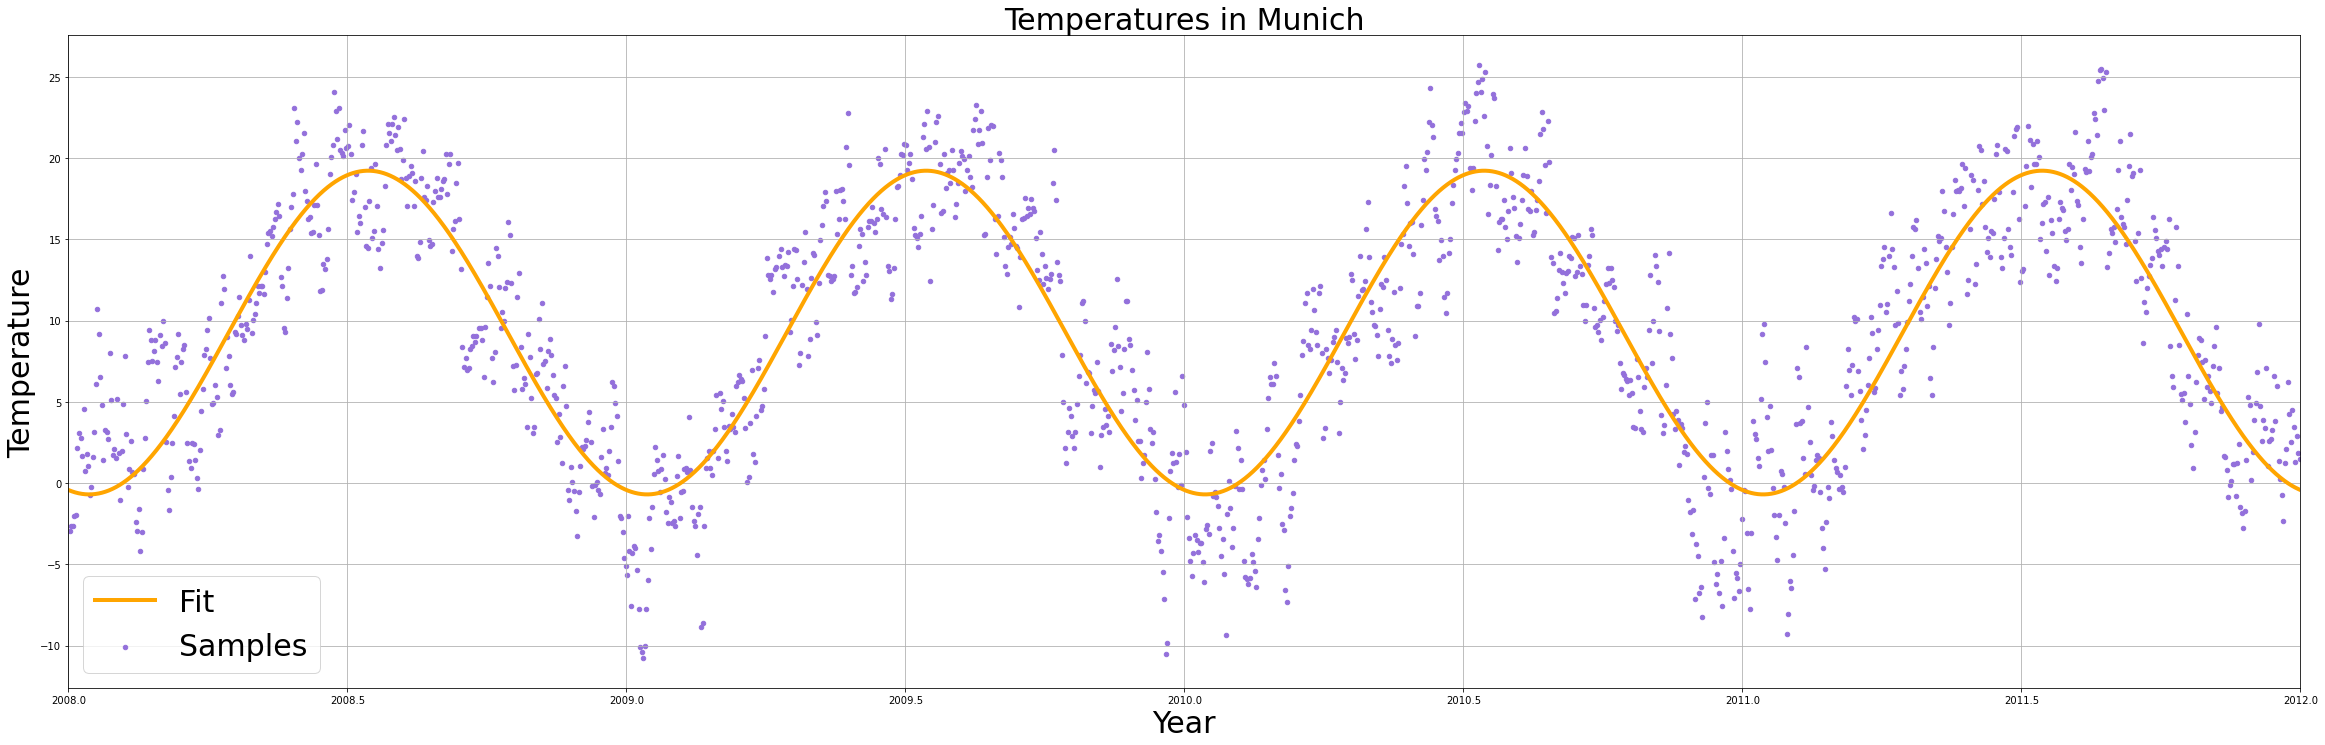

In [11]:
plt = df.plot.scatter( x       = 'Year', 
                       y       = 'Temperature', 
                       c       = 'mediumpurple', 
                       figsize = (40,12),
                       grid    = True,
                       xlim    = [ 2008, 2012],
                       marker  = 'o',
                       label   = 'Samples' )

def f ( t, a , b, c ):
    return a*np.cos( 2*math.pi * t + b ) + c

( a,  b, c ), cov = optimize.curve_fit( f,  
                                        df['Year'], 
                                        df['Temperature'], 
                                        [10, 6, 1.5] )
x = np.linspace( 2008, 2012, 10000 )

y = f( x, a, b, c )

plt.plot( x, 
          y, 
          c         = 'orange', 
          label     = 'Fit',
          linewidth = 4 )

plt.legend( fontsize = 30 )
plt.set_title(  'Temperatures in Munich', fontsize = 30  )
plt.set_ylabel( 'Temperature',            fontsize = 30  )
plt.set_xlabel( 'Year',                   fontsize = 30  )

print( 'The best-fit values of the parameters are:\na = %.2f'%a, '\nb = %.2f '%b,'\nc = %.2f '%c )
print( 'The overall average temperature in Munich is: %.2f'%c,'deg' )
print( 'The typical daily average values predicted by the model for the coldest and hottest time of year are:' )
print( 'c + a = %.2f'%(c+a), 'deg, c - a = %.2f'%(c-a), 'deg')
print( 'The b parameter is a shift over the x ax and it is needed to make possibile',
       'an overlap between the maxima and the minima of the fit function and the data\'s ones.' )

# SSR
SSR_f = 0
for i in range ( len( df.index) ):
    SSR_f = SSR_f + ( f( list( df['Year'])[i], a, b, c ) - list( df['Temperature'])[i])**2

SSR for f(x) and g(x): 
18669.515, 18669.225
Test f(x) vs g(x):
CL: 0.694 , additional parameter necessary: NO


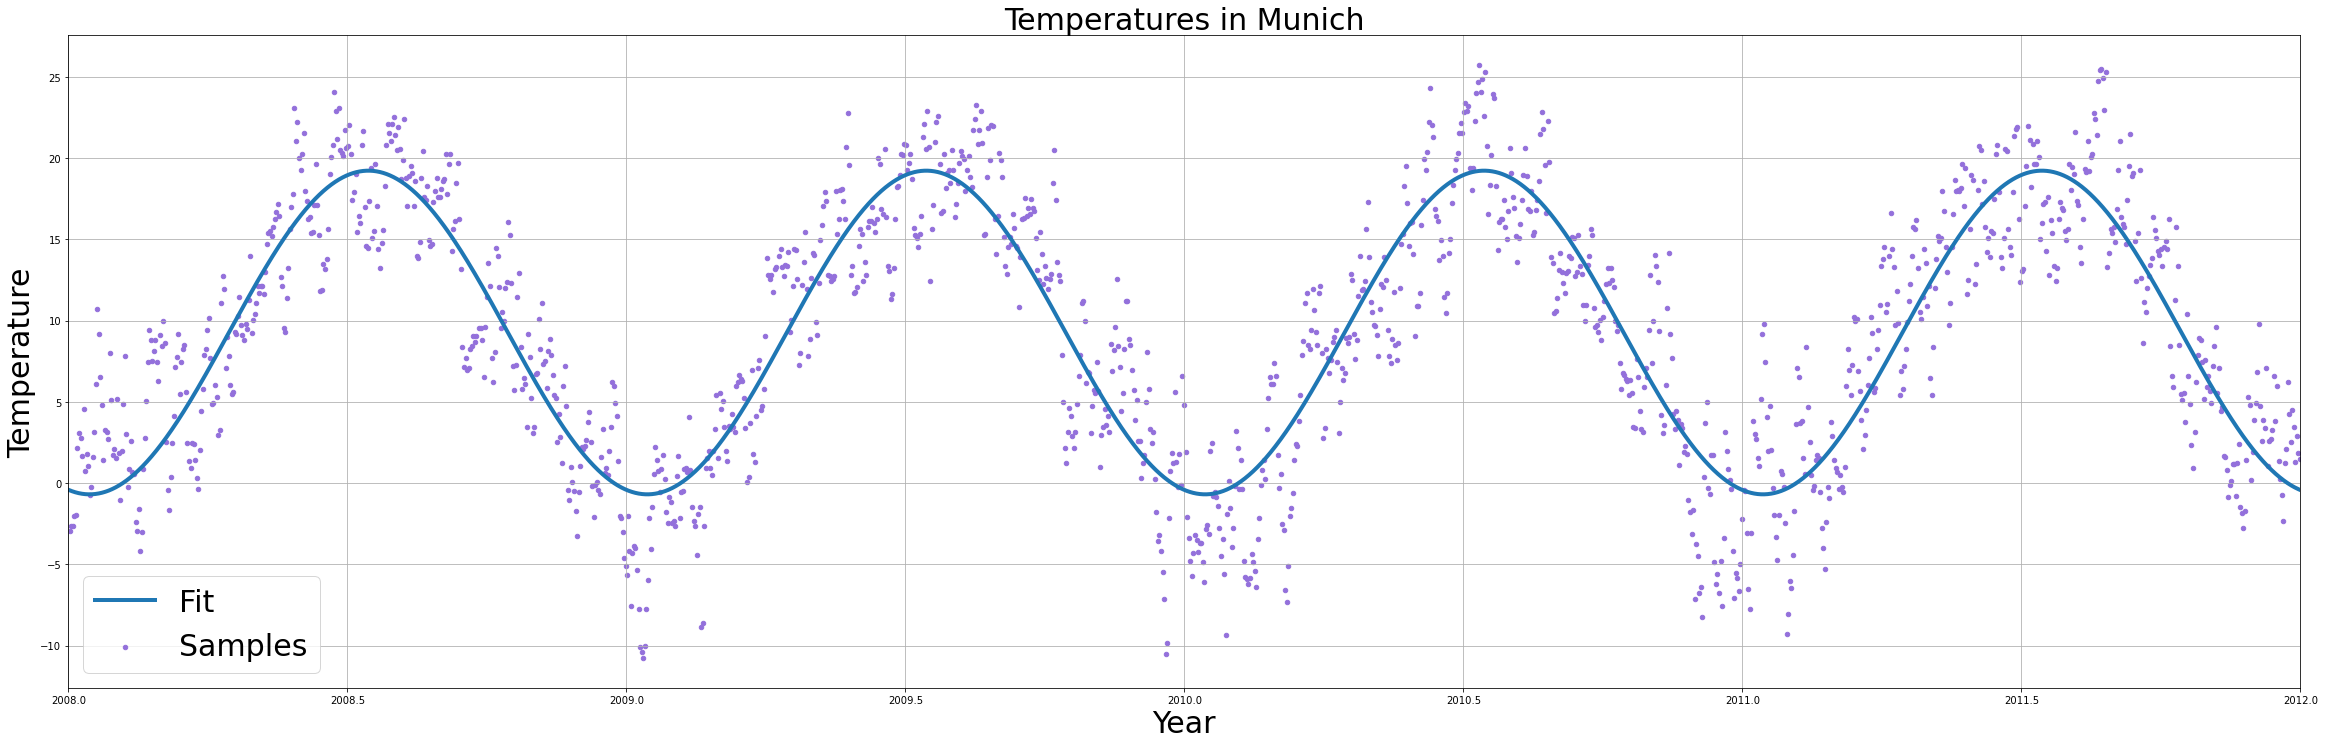

In [12]:
plt = df.plot.scatter( x       = 'Year', 
                       y       = 'Temperature', 
                       c       = 'mediumpurple', 
                       figsize = (40,12),
                       grid    = True,
                       xlim    = [ 2008, 2012],
                       marker  = 'o',
                       label   = 'Samples')

def g (t, a , b, c, d):
    return a*np.cos( (2*math.pi * t *b) +c ) + d

( a,  b, c, d ), cov = optimize.curve_fit( g, 
                                           df['Year'], 
                                           df['Temperature'] )
x = np.linspace( 2008, 2012, 10000 )

y = g( x, a, b, c, d )
plt.plot( x, y,           
          label     = 'Fit',
          linewidth = 4 )

plt.set_title(  'Temperatures in Munich', fontsize = 30 )
plt.set_ylabel( 'Temperature',            fontsize = 30 )
plt.set_xlabel( 'Year',                   fontsize = 30 )
plt.legend( fontsize = 30 )


# SSR
SSR_g = 0
N     = len( df.index )
for i in range ( N ):
    SSR_g = SSR_g + (g(list(df['Year'])[i], a , b, c ,d) - list(df['Temperature'])[i])**2
    
print( 'SSR for f(x) and g(x): ' )
print( '%.3f, %.3f'%(SSR_f, SSR_g) )

# Fisher F-test
def Ftest( SSR_1,  SSR_2, 
           ndof_1, ndof_2,
           nbins, verbose = False):
    F = (( SSR_1 - SSR_2 )/( ndof_2 - ndof_1 )) / ( SSR_2/( nbins - ndof_2 ))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print( "CL: %.3f" % CL, ", additional parameter necessary:", 
                       "YES" if CL < 0.10 else "NO" )
    return CL

print("Test f(x) vs g(x):")
f_vs_g = Ftest(SSR_f, SSR_g, 2, 3, 10000, verbose = True)
